In [1]:
pip install psycopg2-binary catboost optuna -q

Note: you may need to restart the kernel to use updated packages.


# Предсказание исхода игры Dota 2

**Цель работы:** построить модель, которая будет предсказывать исход игры Dota 2 для команды Radiant.

**Метрика для оценки модели:** ROC-AUC

**Входные данные:**
- *train_features.csv*: основной тренировочный набор данных, подготовленный организаторами.
- *test_features.csv*: основной тестовый набор данных, подготовленный организаторами.
- *train_targets.csv*: ответы для игр из тренировочного набора данных (информация о том, выиграла ли команда Radiant).
- *train_matches.jsonl*: необработанные данные для тренировочного набора.
- *test_matches.jsonl*: необработанные данные для тестового набора.

Данные представлены в формате JSON и содержат информацию о каждом игроке в игре. Важно понимать, что в Dota 2 команда Radiant обозначается префиксом r, а команда Dire — d. Номер игрока в команде указывается после префикса (например, r1 - первый игрок команды Radiant, d2 - второй игрок команды Dire).

**Статистика игрока**

**Каждый игрок имеет следующие поля, которые описывают его состояние и действия во время игры:**

- hero_id: идентификатор героя, выбранного игроком.
- K/D/A: количество убийств (Kills), смертей (Deaths) и ассистов (Assists), которые получил игрок.
- lh (last hits): количество крипов противника, убитых игроком.
- denies: количество крипов своей команды, убитых игроком, чтобы противник не получил золото.
- gold: количество золота, имеющееся у игрока.
- xp (experience): количество опыта игрока.
- level: текущий уровень игрока.
- health и max_health: текущее и максимальное количество здоровья игрока.
- max_mana: максимальное количество маны.
- x, y: текущие координаты игрока на карте.
- stuns: время оглушений, наложенных игроком.
- creeps_stacked: количество "стакаемых" крипов, созданных игроком для союзников.
- camps_stacked: количество "лагерей" крипов, улучшенных для фарма.
- rune_pickups: количество собранных рун.
- firstblood_claimed: указывает, участвовал ли игрок в получении "первой крови".
- teamfight_participation: участие игрока в командных боях.
- towers_killed: количество уничтоженных башен.
- roshans_killed: количество убитых Рошанов.
- obs_placed, sen_placed: количество установленных наблюдательных и сторожевых вардов.

Кроме перечисленных полей, также существуют поля с суффиксом _log, которые содержат журналы различных событий. Например:

- buyback_log: информация о том, когда игрок воспользовался "выкупом" (быстрым возвращением в игру после смерти).
- ward_log: информация о времени и месте установки варда.

**Временные ряды**

Кроме обычных данных, JSON-файлы также содержат временные ряды, которые могут быть полезны для анализа динамики игры:
- gold_t: значения золота в разные моменты времени.
- xp_t: значения опыта в разные моменты времени.
- lh_t: количество убийств крипов в разные моменты времени.
- dn_t (denied creeps): количество "отреченных" крипов в разные моменты времени.


**План работы:**
1. Загрузка данных и знакомство с ними.

2. Исследовательский анализ данных (EDA):
- Изучение данных: анализ категориальных и числовых признаков, их распределений и корреляций.
- Обработка пропущенных значений и проверка на выбросы.
- Визуализация распределений и корреляций между признаками.
3. Предобработка данных:
- Создание новых признаков, которые могут улучшить модель (например, общая стоимость предметов у команды).
- Кодирование категориальных признаков (например, с помощью One-Hot Encoding).
- Масштабирование числовых признаков.
4. Построение и обучение моделей:
- Выбор нескольких моделей классификации: Логистическая регрессия, Случайный лес, Градиентный бустинг.
- Обучение моделей на тренировочных данных.
- Настройка гиперпараметров моделей (например, с использованием GridSearch или RandomizedSearch).
5. Оценка качества моделей:
- Использование ROC-AUC для оценки качества моделей на валидационном наборе данных.
- Анализ важности признаков для понимания, какие факторы влияют на предсказания.
6. Интерпретация и выводы:
- Объяснение полученных результатов.
- Разбор ошибки модели и возможных путей улучшения.


## 1. Загрузка данных и знакомство с ними

In [2]:
import os
import ujson as json
import psycopg2 as ps
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from optuna.samplers import RandomSampler

In [3]:
pd.set_option('display.max_columns', None)

Для начала зададим константу  RANDOM_STATE и путь к диску.

In [4]:
RANDOM_STATE = 181024
PATH = '/kaggle/input/jsonll/'

Объявим конфигурацию для подключения к серверу.

In [ ]:
db_config = {
'user': # имя пользователя
'pwd': # пароль
'host': # хост подключения
'port': # порт подключения
'db': # название базы данных,
}

Формируем подключение.

In [6]:
connection = ps.connect(
    host=db_config['host'],
    port=db_config['port'],
    dbname=db_config['db'],
    user=db_config['user'],
    password=db_config['pwd'])

In [7]:
cursor = connection.cursor()
cursor.execute("""SELECT table_schema, table_name
                      FROM information_schema.tables
                      WHERE table_schema != 'information_schema'
                      AND table_schema != 'pg_catalog'
                      AND table_type='BASE TABLE'
                      ORDER BY table_schema, table_name""")
tables = cursor.fetchall()
tables

[('public', 'heroes'),
 ('public', 'matches'),
 ('public', 'play_match_hero'),
 ('public', 'players'),
 ('public', 'test_features'),
 ('public', 'train_features'),
 ('public', 'train_targets')]

Напишем функцию для получения данных из SQL в формате pandas DataFrame.

In [8]:
def read_sql(data, index_col=None):
    query = f'''
    SELECT *
      FROM public.{data}
    '''
    df = pd.read_sql_query(query, con=connection, index_col=index_col)
    return df

Помимо данных таблиц в базе данных есть таблица с информацией о героях, также подгрузим её для добычи дополнительных признаков.

In [9]:
train_features = read_sql('train_features', index_col='match_id_hash')
train_targets = read_sql('train_targets', index_col='match_id_hash')
test_features = read_sql('test_features', index_col='match_id_hash')
heroes = read_sql('heroes')

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [10]:
train_features.info()
train_features.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 33723 entries, 205e85408fa923b744523db4655f7cf7 to de42aea5d0b304be01f2a4aeebac1847
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(30), int64(215)
memory usage: 63.3+ MB


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
205e85408fa923b744523db4655f7cf7,337,22,7,1,2,71,1,0,1,0,983,0,726,749,920,302.93777,3,74,74,9.697543,0,0,5,0,0.333333,0,0,1,0,74,0,1,1,6,1450,18,2487,697,820,554.93805,6,116,122,0.866406,0,0,0,0,0.333333,0,0,0,0,29,0,0,1,3,1795,20,1696,973,980,386.93787,5,76,164,0.000000,0,0,3,0,0.333333,0,0,0,0,42,1,0,0,1,1399,12,1134,800,800,338.93784,4,174,86,5.865247,0,0,1,0,0.333333,0,0,0,0,26,1,1,1,5,968,2,956,524,600,386.93787,3,168,92,9.264421,0,0,1,0,0.666667,0,0,1,0,49,1,0,0,9,2013,27,1363,960,960,314.93780,4,176,88,0.000000,0,0,1,1,0.500000,0,0,0,0,44,0,1,0,0,1395,19,1116,646,780,338.93784,4,86,172,0.000000,0,0,0,0,0.000000,0,0,0,0,91,0,2,1,1,745,0,878,572,620,386.93787,3,176,98,0.000000,0,0,2,0,0.500

In [11]:
train_targets.info()
train_targets.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 33723 entries, a400b8f29dece5f4d266f49f1ae2e98a to 9928dfde50efcbdb2055da23dcdbc101
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_time         33723 non-null  int64 
 1   radiant_win       33723 non-null  bool  
 2   duration          33723 non-null  int64 
 3   time_remaining    33723 non-null  int64 
 4   next_roshan_team  21532 non-null  object
dtypes: bool(1), int64(3), object(1)
memory usage: 1.3+ MB


,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,None
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,None
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,None
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,None
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,None
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire
df50f738c454d430a33b2bf90cb9ef1a,636,False,2059,1423,None


In [12]:
test_features.info()
test_features.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 5952 entries, ee84861e709fc9cf5d48ba0f04b7f43b to 7e45755443aa039c9b59b9efd33a88d0
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(30), int64(215)
memory usage: 11.2+ MB


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ee84861e709fc9cf5d48ba0f04b7f43b,1807,22,7,17,12,32,2,5,14,0,10093,39,9174,1340,1340,554.93805,14,150,110,0.000000,0,0,11,0,0.390244,0,0,0,1,15,7,7,6,14,14134,133,12376,0,2155,837.93830,16,154,176,0.000000,1,1,10,0,0.317073,2,0,1,0,86,4,5,13,3,7846,17,8674,809,1240,1128.93860,13,70,74,45.296062,0,0,6,0,0.414634,0,0,11,8,101,22,2,7,1,17765,80,20122,1700,1700,2148.93950,21,156,130,0.301084,0,0,32,0,0.707317,0,0,0,0,109,6,1,6,36,19040,243,17067,1257,2705,1296.93870,20,130,156,0.000000,8,4,9,0,0.292683,3,1,0,0,76,5,8,2,8,12182,137,15391,1996,2260,1828.93920,18,158,168,68.531250,0,0,1,0,0.350000,0,0,0,1,108,0,9,8,4,9914,134,14370,1960,1960,1248.93870,18,178,150,31.498530,0,0,1,0,0.400000,1,0,1,0,95,2,

In [13]:
heroes.info()
heroes.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18020 entries, 0 to 18019
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              18020 non-null  int64  
 1   id                 18020 non-null  int64  
 2   localized_name     18020 non-null  object 
 3   attack_type        18020 non-null  object 
 4   primary_attr       18020 non-null  object 
 5   roles              18020 non-null  object 
 6   base_health        18020 non-null  int64  
 7   base_health_regen  18020 non-null  float64
 8   base_mana          18020 non-null  int64  
 9   base_mana_regen    18020 non-null  float64
 10  base_armor         18020 non-null  float64
 11  base_mr            18020 non-null  int64  
 12  base_attack_min    18020 non-null  int64  
 13  base_attack_max    18020 non-null  int64  
 14  base_str           18020 non-null  int64  
 15  base_agi           18020 non-null  int64  
 16  base_int           180

,index,id,localized_name,attack_type,primary_attr,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,base_str,base_agi,base_int,str_gain,agi_gain,int_gain,attack_range,projectile_speed,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,cm_enabled,legs,day_vision,night_vision
0,0,123,Hoodwink,Ranged,agi,"['Support', 'Nuker', 'Escape', 'Disabler']",120,0.25,75,0.0,0.0,25,22,29,17,24,21,2.0,3.6,2.9,575,1800,2.0,100,0.40,310,0.9,True,4,1800,800
1,1,86,Rubick,Ranged,int,"['Support', 'Disabler', 'Nuker']",120,0.25,75,0.5,1.0,25,27,33,21,23,25,2.0,2.5,3.7,550,1125,1.7,100,0.40,290,0.7,True,2,1800,800
2,2,52,Leshrac,Ranged,int,"['Carry', 'Support', 'Nuker', 'Pusher', 'Disab...",120,0.25,75,0.0,0.0,25,27,31,20,23,22,2.8,2.8,3.5,575,900,1.7,100,0.40,325,NaN,True,4,1800,800
3,3,51,Clockwerk,Melee,all,"['Initiator', 'Disabler', 'Durable', 'Nuker']",120,0.50,75,0.0,1.0,25,8,10,27,13,18,3.1,2.1,1.7,150,900,1.7,100,0.33,310,NaN,True,2,1800,800
4,4,88,Nyx Assassin,Melee,all,"['Disabler', 'Nuker', 'Initiator', 'Escape']",120,2.00,75,0.0,1.0,25,9,13,17,18,21,2.5,2.1,2.5,150,900,1.7,100,0.46,310,NaN,True,6,1800,800
5,5,107,Earth Spirit,Melee,str,"['Nuker', 'Escape', 'Disabler', 'Initiator', '...",120,1.00,75,0.0,0.0,25,25,35,22,17,18,3.8,2.4,2.1,150,900,1.7,100,0.35,290,NaN,True,2,1800,800
6,6,129,Mars,Melee,str,"['Carry', 'Initiator', 'Disabler', 'Durable']",120,0.25,75,0.5,-1.0,25,26,34,23,20,21,3.7,1.7,2.2,250,900,1.8,100,0.40,310,0.8,True,2,1800,800
7,7,68,Ancient Apparition,Ranged,int,"['Support', 'Disabler', 'Nuker']",120,0.25,75,0.0,-1.0,25,21,31,20,20,23,1.9,2.2,3.1,675,1250,1.7,100,0.45,285,NaN,True,0,1800,800
8,8,79,Shadow Demon,Ranged,int,"['Support', 'Disabler', 'Initiator', 'Nuker']",120,0.25,75,0.0,0.0,25,29,33,23,18,22,2.6,2.2,3.6,500,900,1.7,100,0.35,290,NaN,True,2,1800,800
9,9,54,Lifestealer,Melee,str,"['Carry', 'Durable', 'Escape', 'Disabler']",120,0.25,75,0.0,1.0,25,22,28,25,19,15,2.4,2.6,1.8,150,900,1.7,120,0.39,320,0.9,True,2,1800,800


**Вывод по первому шагу:** загрузили данный и ознакомились с ними. 

Набор данных `train_features`, содержащий тренировочные признаки, состоит из 33723 строк и 246 столбцов, 30 из которых типа float64, 215 - int64, 1 - object.

Набор данных `test_features`, содержащий тестовые признаки, состоит из 5952 строк и 246 столбцов,таких же как в `train_features`.

Набор данных `train_targets`, содержащий целевой признак, состоит из 33723 строк и 6 столбцов, 3 из которых типа - int64, 2 - object, 1 - bool, его мы и должны научиться предсказывать.

Для добычи дополнительных признаков добавили таблицу `heroes`, содержащую характеристики героев.

## 2. Исследовательский анализ данных

Проверим данные на наличие пропусков и явных дубликатов.

In [14]:
print('Количество пропусков в тренировочном наборе признаков:', train_features.isna().sum().sum())
print('Количество явных дубликатов в тренировочном наборе признаков:',train_features.duplicated().sum())
print('Количество пропусков в тестовом наборе признаков:', test_features.isna().sum().sum())
print('Количество явных дубликатов в тестовом наборе признаков:',test_features.duplicated().sum())

Количество пропусков в тренировочном наборе признаков: 0
Количество явных дубликатов в тренировочном наборе признаков: 0
Количество пропусков в тестовом наборе признаков: 0
Количество явных дубликатов в тестовом наборе признаков: 0


Закодируем целевой столбец.

In [15]:
train_targets['radiant_win'] = train_targets['radiant_win'].apply(lambda x: 1 if x else 0)

Далее выполним слияние тренировочных признаков и таргета.

In [16]:
df_train = pd.merge(train_features, train_targets['radiant_win'], left_index=True, right_index=True)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33723 entries, 205e85408fa923b744523db4655f7cf7 to de42aea5d0b304be01f2a4aeebac1847
Columns: 246 entries, game_time to radiant_win
dtypes: float64(30), int64(216)
memory usage: 63.5+ MB


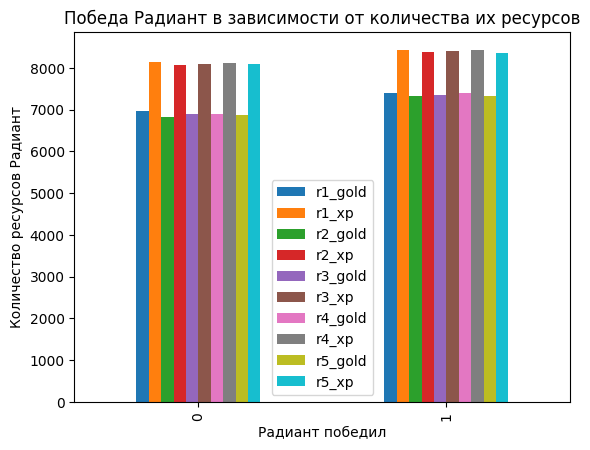

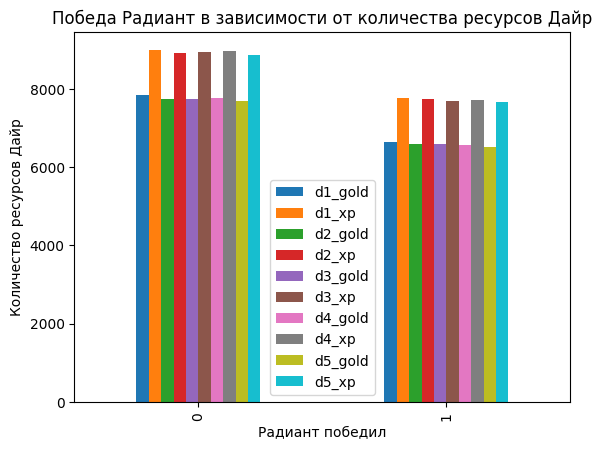

In [18]:
columnd_to_plot_r = ['r1_gold','r1_xp','r2_gold','r2_xp','r3_gold','r3_xp','r4_gold','r4_xp','r5_gold','r5_xp']
df_train.groupby('radiant_win').mean()[columnd_to_plot_r].plot.bar()
plt.title('Победа Радиант в зависимости от количества их ресурсов')
plt.xlabel('Радиант победил')
plt.ylabel('Количество ресурсов Радиант')
plt.show()

columnd_to_plot_d = ['d1_gold','d1_xp','d2_gold','d2_xp','d3_gold','d3_xp','d4_gold','d4_xp','d5_gold','d5_xp']
df_train.groupby('radiant_win').mean()[columnd_to_plot_d].plot.bar()
plt.title('Победа Радиант в зависимости от количества ресурсов Дайр')
plt.xlabel('Радиант победил')
plt.ylabel('Количество ресурсов Дайр')
plt.show()

Очевидно, что чем больше у игроков Радианта ресурсов, тем больше вероятность их победы и наоборот.

**Вывод по второму шагу:** выяснили, что пропуски и дубликаты в данных отсутствуют, рассмотрели очевидные закономерности. Т.к. данные выгружены непосредственно из турнирной игры, поиск аномалий в них особых результатов не принесет. Далее перейдем к созданию новых признаков.

## 3. Предобработка данных

Выполним возможные преобразования признаков, которые приведут к росту метрики (были рассмотрены разные варианты, оставлены только эффективные).

Проведем предварительную обработку таблицы `heroes`.

In [19]:
heroes_short = heroes[['id', 'attack_rate', 'attack_point']]
heroes_short_sorted = heroes_short.sort_values('id')
heroes_short_unique = heroes_short_sorted.groupby('id').first().reset_index()

In [20]:
for i in range(1, 6):
    # Добавим данные об атакующих навыках персонажа из таблицы heroes, т.к. они оказывают влияние на итоговую метрику
    df_train['match_id_hash'] = df_train.index
    df_train = pd.merge(df_train, heroes_short_unique.rename(columns={'id': f'r{i}_hero_id'}), on=f'r{i}_hero_id')
    df_train = df_train.rename(columns={'attack_rate': f'r{i}_attack_rate', 'attack_point': f'r{i}_attack_point'})
    df_train = pd.merge(df_train, heroes_short_unique.rename(columns={'id': f'd{i}_hero_id'}), on=f'd{i}_hero_id')
    df_train = df_train.rename(columns={'attack_rate': f'd{i}_attack_rate', 'attack_point': f'd{i}_attack_point'})
    df_train.set_index('match_id_hash', inplace=True)
    test_features['match_id_hash'] = test_features.index
    test_features = pd.merge(test_features, heroes_short_unique.rename(columns={'id': f'r{i}_hero_id'}), on=f'r{i}_hero_id')
    test_features = test_features.rename(columns={'attack_rate': f'r{i}_attack_rate', 'attack_point': f'r{i}_attack_point'})
    test_features = pd.merge(test_features, heroes_short_unique.rename(columns={'id': f'd{i}_hero_id'}), on=f'd{i}_hero_id')
    test_features = test_features.rename(columns={'attack_rate': f'd{i}_attack_rate', 'attack_point': f'd{i}_attack_point'})
    test_features.set_index('match_id_hash', inplace=True)

    # Добавим квадратичную зависимость в координаты персонажей
    df_train[f'r{i}_xy'] = df_train[f'r{i}_x'] * df_train[f'r{i}_y']
    df_train[f'd{i}_xy'] = df_train[f'd{i}_x'] * df_train[f'd{i}_y']
    test_features[f'r{i}_xy'] = test_features[f'r{i}_x'] * test_features[f'r{i}_y']
    test_features[f'd{i}_xy'] = test_features[f'd{i}_x'] * test_features[f'd{i}_y']

Напишем функцию для определения общекомандной эффективности.

In [21]:
def features_sum(feature):
    df_train[f'r_{feature}'] = df_train[f'r1_{feature}'] \
                                        + df_train[f'r2_{feature}'] \
                                        + df_train[f'r3_{feature}'] \
                                        + df_train[f'r4_{feature}'] \
                                        + df_train[f'r5_{feature}']
    df_train[f'd_{feature}'] = df_train[f'd1_{feature}'] \
                                        + df_train[f'd2_{feature}'] \
                                        + df_train[f'd3_{feature}'] \
                                        + df_train[f'd4_{feature}'] \
                                        + df_train[f'd5_{feature}']

    test_features[f'r_{feature}'] = test_features[f'r1_{feature}'] \
                                                + test_features[f'r2_{feature}'] \
                                                + test_features[f'r3_{feature}'] \
                                                + test_features[f'r4_{feature}'] \
                                                + test_features[f'r5_{feature}']
    test_features[f'd_{feature}'] = test_features[f'd1_{feature}'] \
                                                + test_features[f'd2_{feature}'] \
                                                + test_features[f'd3_{feature}'] \
                                                + test_features[f'd4_{feature}'] \
                                                + test_features[f'd5_{feature}']

In [22]:
features_sum('kills')
features_sum('deaths')
features_sum('assists')
features_sum('health')
features_sum('rune_pickups')
features_sum('towers_killed')
features_sum('sen_placed')
features_sum('gold')

Вычислим количество убийств и золота в единицу времени.

In [23]:
def features_per_second(row):
    if row['game_time'] <= 0:
        for i in range(1, 6):
            row[f'r{i}_kills_per_second'] = 0
            row[f'd{i}_kills_per_second'] = 0
            row[f'r{i}_gold_per_second'] = 0
            row[f'd{i}_gold_per_second'] = 0
        return row[[f'r1_kills_per_second', f'd1_kills_per_second', f'r1_gold_per_second', f'd1_gold_per_second',
                    f'r2_kills_per_second', f'd2_kills_per_second', f'r2_gold_per_second', f'd2_gold_per_second',
                    f'r3_kills_per_second', f'd3_kills_per_second', f'r3_gold_per_second', f'd3_gold_per_second',
                    f'r4_kills_per_second', f'd4_kills_per_second', f'r4_gold_per_second', f'd4_gold_per_second',
                    f'r5_kills_per_second', f'd5_kills_per_second', f'r5_gold_per_second', f'd5_gold_per_second']]

    for i in range(1, 6):
        row[f'r{i}_kills_per_second'] = row[f'r{i}_kills'] / row['game_time']
        row[f'd{i}_kills_per_second'] = row[f'd{i}_kills'] / row['game_time']
        row[f'r{i}_gold_per_second'] = row[f'r{i}_gold'] / row['game_time']
        row[f'd{i}_gold_per_second'] = row[f'd{i}_gold'] / row['game_time']

    return row[[f'r1_kills_per_second', f'd1_kills_per_second', f'r1_gold_per_second', f'd1_gold_per_second',
                    f'r2_kills_per_second', f'd2_kills_per_second', f'r2_gold_per_second', f'd2_gold_per_second',
                    f'r3_kills_per_second', f'd3_kills_per_second', f'r3_gold_per_second', f'd3_gold_per_second',
                    f'r4_kills_per_second', f'd4_kills_per_second', f'r4_gold_per_second', f'd4_gold_per_second',
                    f'r5_kills_per_second', f'd5_kills_per_second', f'r5_gold_per_second', f'd5_gold_per_second']]

In [24]:
new_features_train = df_train.apply(features_per_second, axis=1)
df_train = pd.merge(df_train, new_features_train, left_index=True, right_index=True)
new_features_test = test_features.apply(lambda x: features_per_second(x), axis=1)
test_features = pd.merge(test_features, new_features_test, left_index=True, right_index=True)

### 3.1 Извлечение из json

In [25]:
def read_matches(matches_file):

    MATCHES_COUNT = {
        'test_matches.jsonl': len(test_features),
        'train_matches.jsonl': len(df_train),
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)

    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            yield json.loads(line)

In [26]:
def add_new_features(df_features, matches_file):
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # добавим количество покупок, использований способностей и убийств подряд

        for player in match['players'][:5]:
            player_num_r = player['player_slot'] + 1
            df_features.loc[match_id_hash, f'r{player_num_r}_total_purchases'] = sum(player['purchase'].values())
            df_features.loc[match_id_hash, f'r{player_num_r}_ability_uses'] =  sum(player['ability_uses'].values())
            df_features.loc[match_id_hash, f'r{player_num_r}_kill_streaks'] =  sum(player['kill_streaks'].values())

        for player in match['players'][5:]:
            player_num_d = player['player_slot'] - 127
            df_features.loc[match_id_hash, f'd{player_num_d}_total_purchases'] = sum(player['purchase'].values())
            df_features.loc[match_id_hash, f'd{player_num_d}_ability_uses'] = sum(player['ability_uses'].values())
            df_features.loc[match_id_hash, f'd{player_num_d}_kill_streaks'] = sum(player['kill_streaks'].values())
 
    return df_features.fillna('empty_item')

In [27]:
df_train = add_new_features(df_train,
                 os.path.join(PATH,
                              'train_matches.jsonl'))

test_features = add_new_features(test_features,
                 os.path.join(PATH,
                              'test_matches.jsonl'))

100%|██████████| 5952/5952 [01:11<00:00, 83.28it/s]


In [28]:
df_train.info()
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 33723 entries, 205e85408fa923b744523db4655f7cf7 to de42aea5d0b304be01f2a4aeebac1847
Columns: 342 entries, game_time to d5_kill_streaks
dtypes: float64(100), int64(242)
memory usage: 89.3+ MB


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win,r1_attack_rate,r1_attack_point,d1_attack_rate,d1_attack_point,r1_xy,d1_xy,r2_attack_rate,r2_attack_point,d2_attack_rate,d2_attack_point,r2_xy,d2_xy,r3_attack_rate,r3_attack_point,d3_attack_rate,d3_attack_point,r3_xy,d3_xy,r4_attack_rate,r4_attack_point,d4_attack_rate,d4_attack_point,r4_xy,d4_xy,r5_attack_rate,r5_attack_point,d5_attack_rate,d5_attack_point,r5_xy,d5_xy,r_kills,d_kills,r_deaths,d_deaths,r_assists,d_assists,r_health,d_health,r_rune_pickups,d_rune_pickups,r_towers_killed,d_towers_killed,r_sen_placed,d_sen_placed,r_gold,d_gold,r1_kills_per_second,d1_kills_per_second,r1_gold_per_second,d1_gold_per_second,r2_kills_per_second,d2_kills_per_second,r2_gold_per_second,d2_gold_per_second,r3_kills_per_second,d3_kills_per_second,r3_gold_per_second,d3_gold_per_second,r4_kills_per_second,d4_kills_per_second,r4_gold_per_second,d4_gold_per_second,r5_kills_per_second,d5_kills_per_second,r5_gold_per_second,d5_gold_per_second,r1_total_purchases

In [29]:
test_features.info()
test_features.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 5952 entries, ee84861e709fc9cf5d48ba0f04b7f43b to 7e45755443aa039c9b59b9efd33a88d0
Columns: 341 entries, game_time to d5_kill_streaks
dtypes: float64(100), int64(241)
memory usage: 15.7+ MB


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,r1_attack_rate,r1_attack_point,d1_attack_rate,d1_attack_point,r1_xy,d1_xy,r2_attack_rate,r2_attack_point,d2_attack_rate,d2_attack_point,r2_xy,d2_xy,r3_attack_rate,r3_attack_point,d3_attack_rate,d3_attack_point,r3_xy,d3_xy,r4_attack_rate,r4_attack_point,d4_attack_rate,d4_attack_point,r4_xy,d4_xy,r5_attack_rate,r5_attack_point,d5_attack_rate,d5_attack_point,r5_xy,d5_xy,r_kills,d_kills,r_deaths,d_deaths,r_assists,d_assists,r_health,d_health,r_rune_pickups,d_rune_pickups,r_towers_killed,d_towers_killed,r_sen_placed,d_sen_placed,r_gold,d_gold,r1_kills_per_second,d1_kills_per_second,r1_gold_per_second,d1_gold_per_second,r2_kills_per_second,d2_kills_per_second,r2_gold_per_second,d2_gold_per_second,r3_kills_per_second,d3_kills_per_second,r3_gold_per_second,d3_gold_per_second,r4_kills_per_second,d4_kills_per_second,r4_gold_per_second,d4_gold_per_second,r5_kills_per_second,d5_kills_per_second,r5_gold_per_second,d5_gold_per_second,r1_total_purchases,r1_ability_

Выделим числовые, категориальные признаки и таргет. 

Уберем некоторые исходные фичи, которые мы использовали при создании новых, и при этом удаление которых не ведет к ухудшению метрики. 

In [30]:
cat_features = ['game_mode', 'lobby_type',
            'r1_hero_id', 'r1_firstblood_claimed',
            'r2_hero_id', 'r2_firstblood_claimed',
            'r3_hero_id', 'r3_firstblood_claimed',
            'r4_hero_id', 'r4_firstblood_claimed',
            'r5_hero_id', 'r5_firstblood_claimed',
            'd1_hero_id', 'd1_firstblood_claimed',
            'd2_hero_id', 'd2_firstblood_claimed',
            'd3_hero_id', 'd3_firstblood_claimed',
            'd4_hero_id', 'd4_firstblood_claimed',
            'd5_hero_id', 'd5_firstblood_claimed']
num_features = df_train.drop(['radiant_win', *cat_features,
                              *[f'r{i}_x' for i in range(1, 6)],
                              *[f'r{i}_y' for i in range(1, 6)],
                              *[f'd{i}_x' for i in range(1, 6)],
                              *[f'd{i}_y' for i in range(1, 6)],
                              *[f'r{i}_rune_pickups' for i in range(1, 6)],
                              *[f'd{i}_rune_pickups' for i in range(1, 6)]],
                              axis=1).columns.tolist()
target_column = df_train['radiant_win']

In [31]:
X = df_train[cat_features + num_features]
y = target_column

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

In [32]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [33]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
    ],
    remainder='drop',
    n_jobs=-1)

**Вывод по третьему шагу:** добавили дополнительные признаки, содержащие информацию об атакующих спопобностях героя, из таблицы `heroes`, сформировали новые признаки из имеющихся, а именно: рассчитали результативные действия на команду целиком, рассчитали убийства и золото каждого игрока в единицу времени. Из json файлов добавили в основные данные количество покупок, использований способностей и убийств подряд. В итоге получили 341 признак для обучения.

## 4. Построение и обучение моделей

### 4.1 Логистическая регрессия

In [34]:
def objective(trial):    
    # Список гиперпараметров для перебора (для LogisticRegression)
    penalty = trial.suggest_categorical('penalty', ["l2"])
    c = trial.suggest_float("C", 1e-5, 1, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"])
        
    # Определяю модель машинного обучения, которой передаются гиперпараметры
    estimator = LogisticRegression(penalty=penalty, C=c, solver=solver, random_state=RANDOM_STATE, max_iter=1000)

    # Прикручиваю пайплайны
    logreg_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
    # Код для вычисления метрики качества.
    # В этом проекте я вычисляю roc_auc методом кросс-валидации
    auc = cross_val_score(logreg_pipeline, X_train, y_train, cv=3, scoring= 'roc_auc').mean()
    return auc

In [35]:
study = optuna.create_study(direction="maximize", study_name="LR-2024-11-07")
study.optimize(objective, n_trials=10)

[I 2024-11-08 15:22:32,660] A new study created in memory with name: LR-2024-11-07
[I 2024-11-08 15:23:20,638] Trial 0 finished with value: 0.8097206215546274 and parameters: {'penalty': 'l2', 'C': 0.956361353262535, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8097206215546274.
[I 2024-11-08 15:37:42,851] Trial 1 finished with value: 0.8177473308335382 and parameters: {'penalty': 'l2', 'C': 0.015815887568212495, 'solver': 'saga'}. Best is trial 1 with value: 0.8177473308335382.
[I 2024-11-08 15:38:13,392] Trial 2 finished with value: 0.8187333235055818 and parameters: {'penalty': 'l2', 'C': 0.023093729183969125, 'solver': 'liblinear'}. Best is trial 2 with value: 0.8187333235055818.
[I 2024-11-08 15:38:23,289] Trial 3 finished with value: 0.7970605747049735 and parameters: {'penalty': 'l2', 'C': 0.00011463324158637987, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.8187333235055818.
[I 2024-11-08 15:38:32,411] Trial 4 finished with value: 0.7922410837081904 and parameters: {'p

In [36]:
best_trial = study.best_trial
best_params = best_trial.params

In [37]:
best_logreg = LogisticRegression(**best_params)

In [38]:
best_logreg.fit(X_train, y_train)

LogisticRegression(C=0.03938134622612342, solver='liblinear')

In [39]:
logreg_y_pred_proba = best_logreg.predict_proba(X_valid)[:,1]
logreg_y_pred = best_logreg.predict(X_valid)

In [40]:
roc_auc_score(y_valid, logreg_y_pred_proba)

0.8166839406974398

### 4.2 CatBoost

In [41]:
def objective(trial):    
    # Список гиперпараметров для перебора (для CatBoostClassifier)
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    # Определяю модель машинного обучения, которой передаются гиперпараметры
    estimator = CatBoostClassifier(**param, verbose=False)

    # Прикручиваю пайплайны
    clf_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
    # Код для вычисления метрики качества.
    # В этом проекте я вычисляю roc_auc методом кросс-валидации
    auc = cross_val_score(clf_pipeline, X_train, y_train, cv=3, scoring= 'roc_auc').mean()
    return auc

In [42]:
study = optuna.create_study(direction="maximize", study_name="CBC-2024-11-07")
 
study.optimize(objective, n_trials=10)

[I 2024-11-08 15:50:28,804] A new study created in memory with name: CBC-2024-11-07
[I 2024-11-08 15:55:01,824] Trial 0 finished with value: 0.8005678123570578 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08710211576050711, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.4393649688529617}. Best is trial 0 with value: 0.8005678123570578.
[I 2024-11-08 15:57:27,901] Trial 1 finished with value: 0.7920770460042575 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05581058948413046, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.948125972966206}. Best is trial 0 with value: 0.8005678123570578.
[I 2024-11-08 16:07:58,865] Trial 2 finished with value: 0.8141653889383509 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07097941714711745, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8132769158222208}. Best is

In [43]:
print(study.best_trial)

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.8141653889383509], datetime_start=datetime.datetime(2024, 11, 8, 15, 57, 27, 903105), datetime_complete=datetime.datetime(2024, 11, 8, 16, 7, 58, 864880), params={'objective': 'Logloss', 'colsample_bylevel': 0.07097941714711745, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8132769158222208}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'objective': CategoricalDistribution(choices=('Logloss', 'CrossEntropy')), 'colsample_bylevel': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'depth': IntDistribution(high=12, log=False, low=3, step=1), 'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian', 'Bernoulli')), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=2, value=None)


In [44]:
best_trial = study.best_trial
best_params = best_trial.params

In [45]:
best_cb = CatBoostClassifier(**best_params)

In [46]:
best_cb.fit(X_train, y_train)

Learning rate set to 0.04207
0:	learn: 0.6851869	total: 140ms	remaining: 2m 19s
1:	learn: 0.6756030	total: 305ms	remaining: 2m 32s
2:	learn: 0.6684760	total: 440ms	remaining: 2m 26s
3:	learn: 0.6625709	total: 589ms	remaining: 2m 26s
4:	learn: 0.6564957	total: 715ms	remaining: 2m 22s
5:	learn: 0.6495186	total: 864ms	remaining: 2m 23s
6:	learn: 0.6444663	total: 1.01s	remaining: 2m 23s
7:	learn: 0.6407341	total: 1.16s	remaining: 2m 23s
8:	learn: 0.6364732	total: 1.28s	remaining: 2m 21s
9:	learn: 0.6321848	total: 1.44s	remaining: 2m 22s
10:	learn: 0.6287402	total: 1.59s	remaining: 2m 23s
11:	learn: 0.6249691	total: 1.75s	remaining: 2m 23s
12:	learn: 0.6213457	total: 1.9s	remaining: 2m 23s
13:	learn: 0.6181513	total: 2.04s	remaining: 2m 23s
14:	learn: 0.6159714	total: 2.17s	remaining: 2m 22s
15:	learn: 0.6127974	total: 2.33s	remaining: 2m 23s
16:	learn: 0.6094830	total: 2.45s	remaining: 2m 21s
17:	learn: 0.6067361	total: 2.58s	remaining: 2m 21s
18:	learn: 0.6046395	total: 2.73s	remaining: 2

In [47]:
cb_y_pred_proba = best_cb.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, cb_y_pred_proba)

0.815606609913174

**Вывод по четвертому шагу:** лучше всего себя показала модель логистической регрессии. Видимо, признаки и таргет имеют хорошую линейную зависимость. Далее рассмотрим получившуюся лучшую модель.

## 5. Оценка качества лучшей модели

**Confusion_matrix**

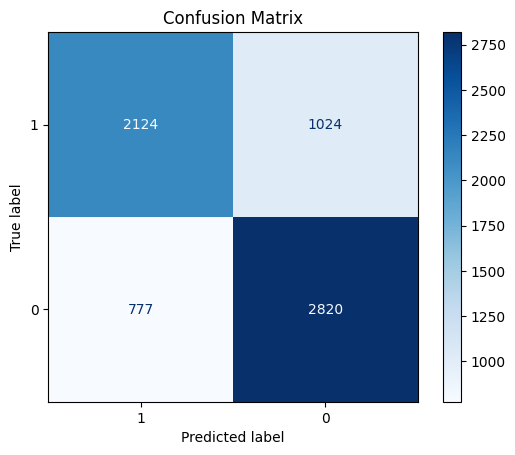

In [48]:
# рассчитываем confusion matrix
cm = confusion_matrix(y_valid, logreg_y_pred)

# строим confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_valid.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Видим, что наша модель примерно одинаково хорошо справляется с определением классов, но с 1 - чуть хуже.

**ROC-AUC**

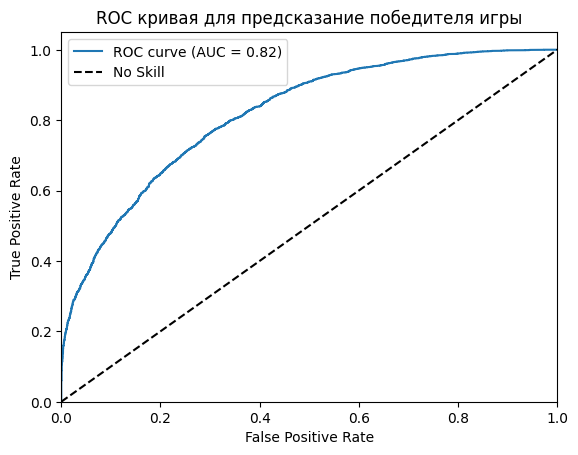

In [56]:
# рассчитываем ROC кривую
fpr, tpr, thresholds = roc_curve(y_valid, logreg_y_pred_proba)
roc_auc = roc_auc_score(y_valid, logreg_y_pred_proba)
# строим ROC кривую
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для предсказание победителя игры')
plt.legend()
plt.show()

Можем наблюдать, что площадь под кривой достаточно близка к единице, т.е. модель достаточно хорошо различает классы.

**Анализ важности признаков**

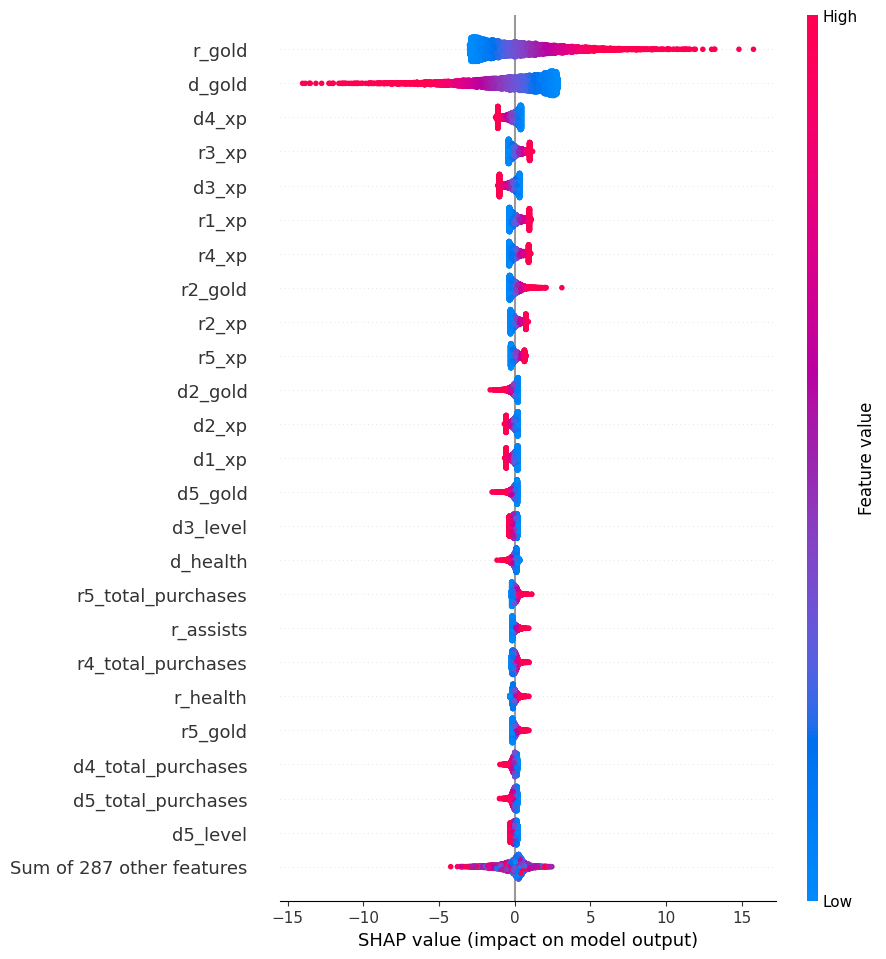

In [50]:
explainer = shap.LinearExplainer(best_logreg, X_train)
shap_values = explainer(X_valid)
shap.plots.beeswarm(shap_values, max_display=25)

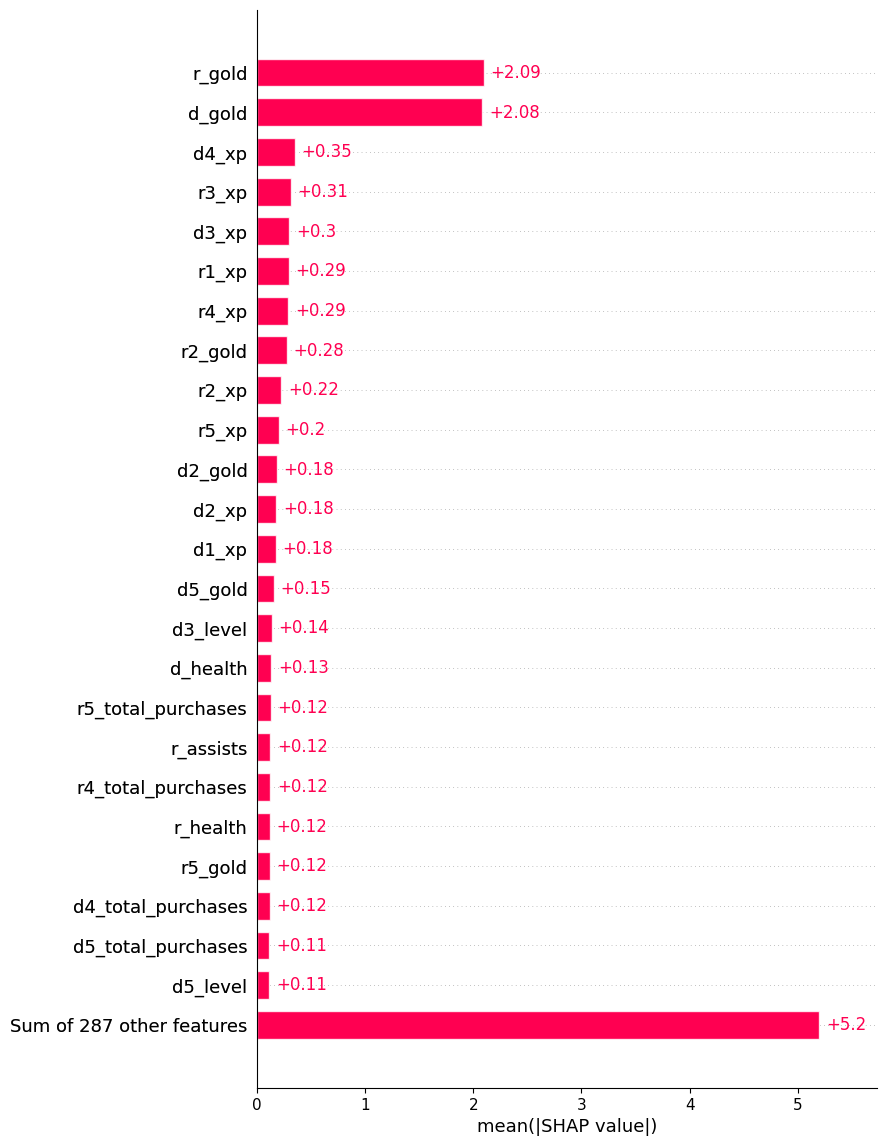

In [51]:
shap.plots.bar(shap_values, max_display=25) 

Наибольшее влияние на результат оказывает количество золота у игроков. Чем больше золота - тем вероятнее победа команды. Уровень персонажа и опыт также важны, но стоит отметить, что и все оставшиеся признаки в сумме оказывают значительное влияние на предсказание.

**Для загрузки на Kaggle**

In [52]:
best_model = best_logreg
result = pd.DataFrame(data={'ID': test_features.index, 'submission': None})
result['submission'] = best_model.predict_proba(test_features[cat_features + num_features])[:,1]

In [53]:
result

,ID,submission
0,ee84861e709fc9cf5d48ba0f04b7f43b,0.984213
1,a9475ee47c8a10d6cf37c1461814653e,0.447261
2,b56ea18db1408fc68263757232c1facb,0.528456
3,9587640246910f0e1b033a6c8f6d8211,0.821476
4,3eb93fbd9056ebdb52ffff84e6c3664a,0.407290
...,...,...
5947,7b7281ee9c15e318537a93de4ad9ecf8,0.578135
5948,637d118614945c9f0fe7069ed12e6d96,0.165049
5949,1b061c289dbd29a8a25aaf7801a9d2c1,0.458161
5950,ba80794174c19b3498c26f3257b97645,0.057612


In [54]:
result.to_csv(r'result.csv', index= False)

На Kaggle быо получено значение метрики, равное 0.825.


## 6. Общий вывод

Загрузили данный и ознакомились с ними. 

Набор данных `train_features`, содержащий тренировочные признаки, состоит из 33723 строк и 246 столбцов, 30 из которых типа float64, 215 - int64, 1 - object.

Набор данных `test_features`, содержащий тестовые признаки, состоит из 5952 строк и 246 столбцов,таких же как в `train_features`.

Набор данных `train_targets`, содержащий целевой признак, состоит из 33723 строк и 6 столбцов, 3 из которых типа - int64, 2 - object, 1 - bool, его мы и должны научиться предсказывать.

Для добычи дополнительных признаков добавили таблицу `heroes`, содержащую характеристики героев.

После чего исследовали данные. Выяснили, что пропуски и дубликаты в данных отсутствуют, рассмотрели очевидные закономерности. Т.к. данные выгружены непосредственно из турнирной игры, поиск аномалий в них особых результатов не принесет.

Далее добавили дополнительные признаки, содержащие информацию об атакующих спопобностях героя, из таблицы `heroes`, сформировали новые признаки из имеющихся, а именно: рассчитали результативные действия на команду целиком, рассчитали убийства и золото каждого игрока в единицу времени. Из json файлов добавили в основные данные количество покупок, использований способностей и убийств подряд. В итоге получили 341 признак для обучения.

Обучили две модели - Логистическая регрессия и CatBoost, лучше всего себя показала первая, вероятно, признаки и таргет имеют хорошую линейную зависимость. На тестовых данных получили метрику `ROC-AUC` равную 0,825.

Модель хорошо различает классы и практически с одинаковой точностью предсказывает каждый из них.

Наибольшее влияние на результат оказывает количество золота у игроков. Чем больше золота - тем вероятнее победа команды. Уровень персонажа и опыт также важны, но стоит отметить, что и все оставшиеся признаки в сумме оказывают значительное влияние на предсказание.

